# Blibliotecas & Downloads


In [2]:
import pandas as pd
import math

import networkx as nx
import matplotlib.pyplot as plt


# Monta arquivo para trabalho

### Dados de aeroporto

In [15]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
	               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
	                        names = airport_col, index_col = 0)

airport_df.to_csv('aeroporto_mundo.csv') # Salvei o arquivo no diretório para restaurar, caso o link github esteja quebrado.

## Dados das rotas

### Arquivo com geolocalizacao

In [4]:
def monta_pos(IATA):
  airport_pos_df = airport_df.loc[airport_df['IATA'].isin(IATA)][['IATA', 'Lat', 'Long']]
  airport_pos_df.reset_index(inplace=True)
  
  pos = {}
  for index, elem in enumerate (airport_pos_df['IATA']):    
    pos[elem] =  (airport_pos_df.loc[index ,'Long'], airport_pos_df.loc[index ,'Lat']) 

  found = len(airport_pos_df.loc[~airport_pos_df['Lat'].isnull()])
  print(f'{found} Aeroportos com Lat, Long')  

  return pos
  

### Monta topo de rotas, e prepara a lista de aeroportos

In [5]:
def routes_top(routes_grouped_df, top):
  routes_grouped_df_top = routes_grouped_df.loc[routes_grouped_df['counts'] > top]  

  IATA_dest = set(routes_grouped_df_top['IATA_dest'].unique())
  print(f'{len(IATA_dest)} Aeroportos encontrados destinos')

  IATA_orig = set(routes_grouped_df_top['IATA_orig'].unique())  
  print(f'{len(IATA_orig)} Aeroportos encontrados origem')

  IATA = IATA_dest.union(IATA_orig)
  print(f'{len(IATA)} Aeroportos encontrados total')
  return IATA, routes_grouped_df_top

### Função principal de montagem de rotas

In [6]:
def monta_rotas(ano, top):
  ######################################################
  # Define nomes mais faceis de manipular para a tabela
  ######################################################
  '''
  0 'ICAO Empresa Aérea'	'Número Voo'	'Código Autorização (DI)'	'Código Tipo Linha'	'ICAO Aeródromo Origem'	'ICAO Aeródromoo Destino'	
  'Partida Prevista'	'Partida Real'	'Chegada Prevista'	'Chegada Real'	
  'Situação Voo'	'Código Justificativa'	'ano'	'mes'                 
  '''

  routes_col = ['company_id', 'flight_no', 'auth_code', 'line_code','ICAO_orig', 'ICAO_dest', 
                'depature_estimated', 'depature_time', 'arrival_estimated', 'arriaval_time', 
                'flight_status', 'flight_status_cause_code', 'ano', 'mes']

  #Carrega a lista do ano, porém eliminando os voos cancelados
  # routes_df = pd.read_csv(f"/content/drive/MyDrive/VRA/VRA_ANO_{ano}.csv"
  #                           ,header=0 ,names = routes_col, index_col = 0) #
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"
                            ,compression='zip' ,header=0 ,names = routes_col, index_col = 0) #

  routes_df = routes_df.loc[routes_df['flight_status'] != 'CANCELADO']

  #Agrupa, mantendo so o que entrara no grafo
  routes_grouped_df = routes_df.groupby(['ICAO_orig', 'ICAO_dest']).size().reset_index(name='counts')                          
  
  ######################################################################
  #Jaz a junção com o Airport.dat para trocar para o codigo de 3 letras
  ######################################################################
  #Join origem
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_orig', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA', 'Country', 'ICAO_dest', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_orig', 'Country': 'Country_orig'}, inplace = True)
  #Join Destino
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_dest', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'Country_orig', 'IATA', 'Country', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_dest', 'Country': 'Country_dest'}, inplace = True)

  #Filtra somente Brazil, e mantem somente as colunas necessarias
  routes_grouped_df = (routes_grouped_df
                        .loc[routes_grouped_df['Country_orig'] == 'Brazil']
                        .loc[routes_grouped_df['Country_dest'] == 'Brazil']
                        .loc[routes_grouped_df['IATA_orig'] != routes_grouped_df['IATA_dest']]
                        .loc[routes_grouped_df['IATA_orig'].str.len() == 3]
                        .loc[routes_grouped_df['IATA_dest'].str.len() == 3]
                        .sort_values(by=['counts'], ascending=False)
                      )
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'IATA_dest', 'counts']]  
  
  #prepara os DataFrames que serão utilizados
  IATA, routes_grouped_df_top = routes_top(routes_grouped_df, top)
  pos = monta_pos(IATA)
  return routes_grouped_df_top, pos


# Grafos

## monta o grafo

In [7]:
def desenha_grafo2(ano, type='Map', all=True):
  G = nx.Graph()
  pos = {}
  airport_brasil_df = airport_df.loc[airport_df['Country'] == 'Brazil'].loc[airport_df['IATA'].str.len() == 3]
  airport_brasil_df.reset_index(inplace=True)

  for index, elem in enumerate(airport_brasil_df['IATA']):
    pos[elem] =  (airport_brasil_df.loc[index ,'Long'], airport_brasil_df.loc[index ,'Lat']) 


  #ignorar pos, ja adicionei todos os aeroportos
  routes, pos_ignore = monta_rotas(ano, 1)
  routes.reset_index(inplace=True)
  for index, elem in enumerate(routes['IATA_orig']):
    G.add_edge(routes.loc[index, 'IATA_orig'], routes.loc[index, 'IATA_dest'])


  options = {
      "font_size": 36,
      "node_size": 7000,
      "node_color": "#336699CC",
      "edgecolors": "#002060",
      "edge_color": "#D34817",
      "linewidths": 5,
      "width": [1+int(math.log(x, 30)) for x in routes['counts'].to_list()],
      "with_labels": True
  }

  plt.figure(figsize = (50,50))
  if type == 'Map':
    nx.draw_networkx(G, pos, **options)
    plt.savefig(f'brasil_2_map_{ano}.png', dpi=50)
  elif type == 'Random':
    nx.draw_random(G, **options)
    plt.savefig(f'brasil_2__random_{ano}.png', dpi=50)    
  elif type == 'Best':
    nx.draw(G, **options)
    plt.savefig(f'brasil_2_best_{ano}.png', dpi=50)        
  else:
    nx.draw_shell(G, **options)
    plt.savefig(f'brasil_2_shell_{ano}.png', dpi=50)

  return G
  #G.add_node(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


117 Aeroportos encontrados destinos
116 Aeroportos encontrados origem
118 Aeroportos encontrados total
118 Aeroportos com Lat, Long


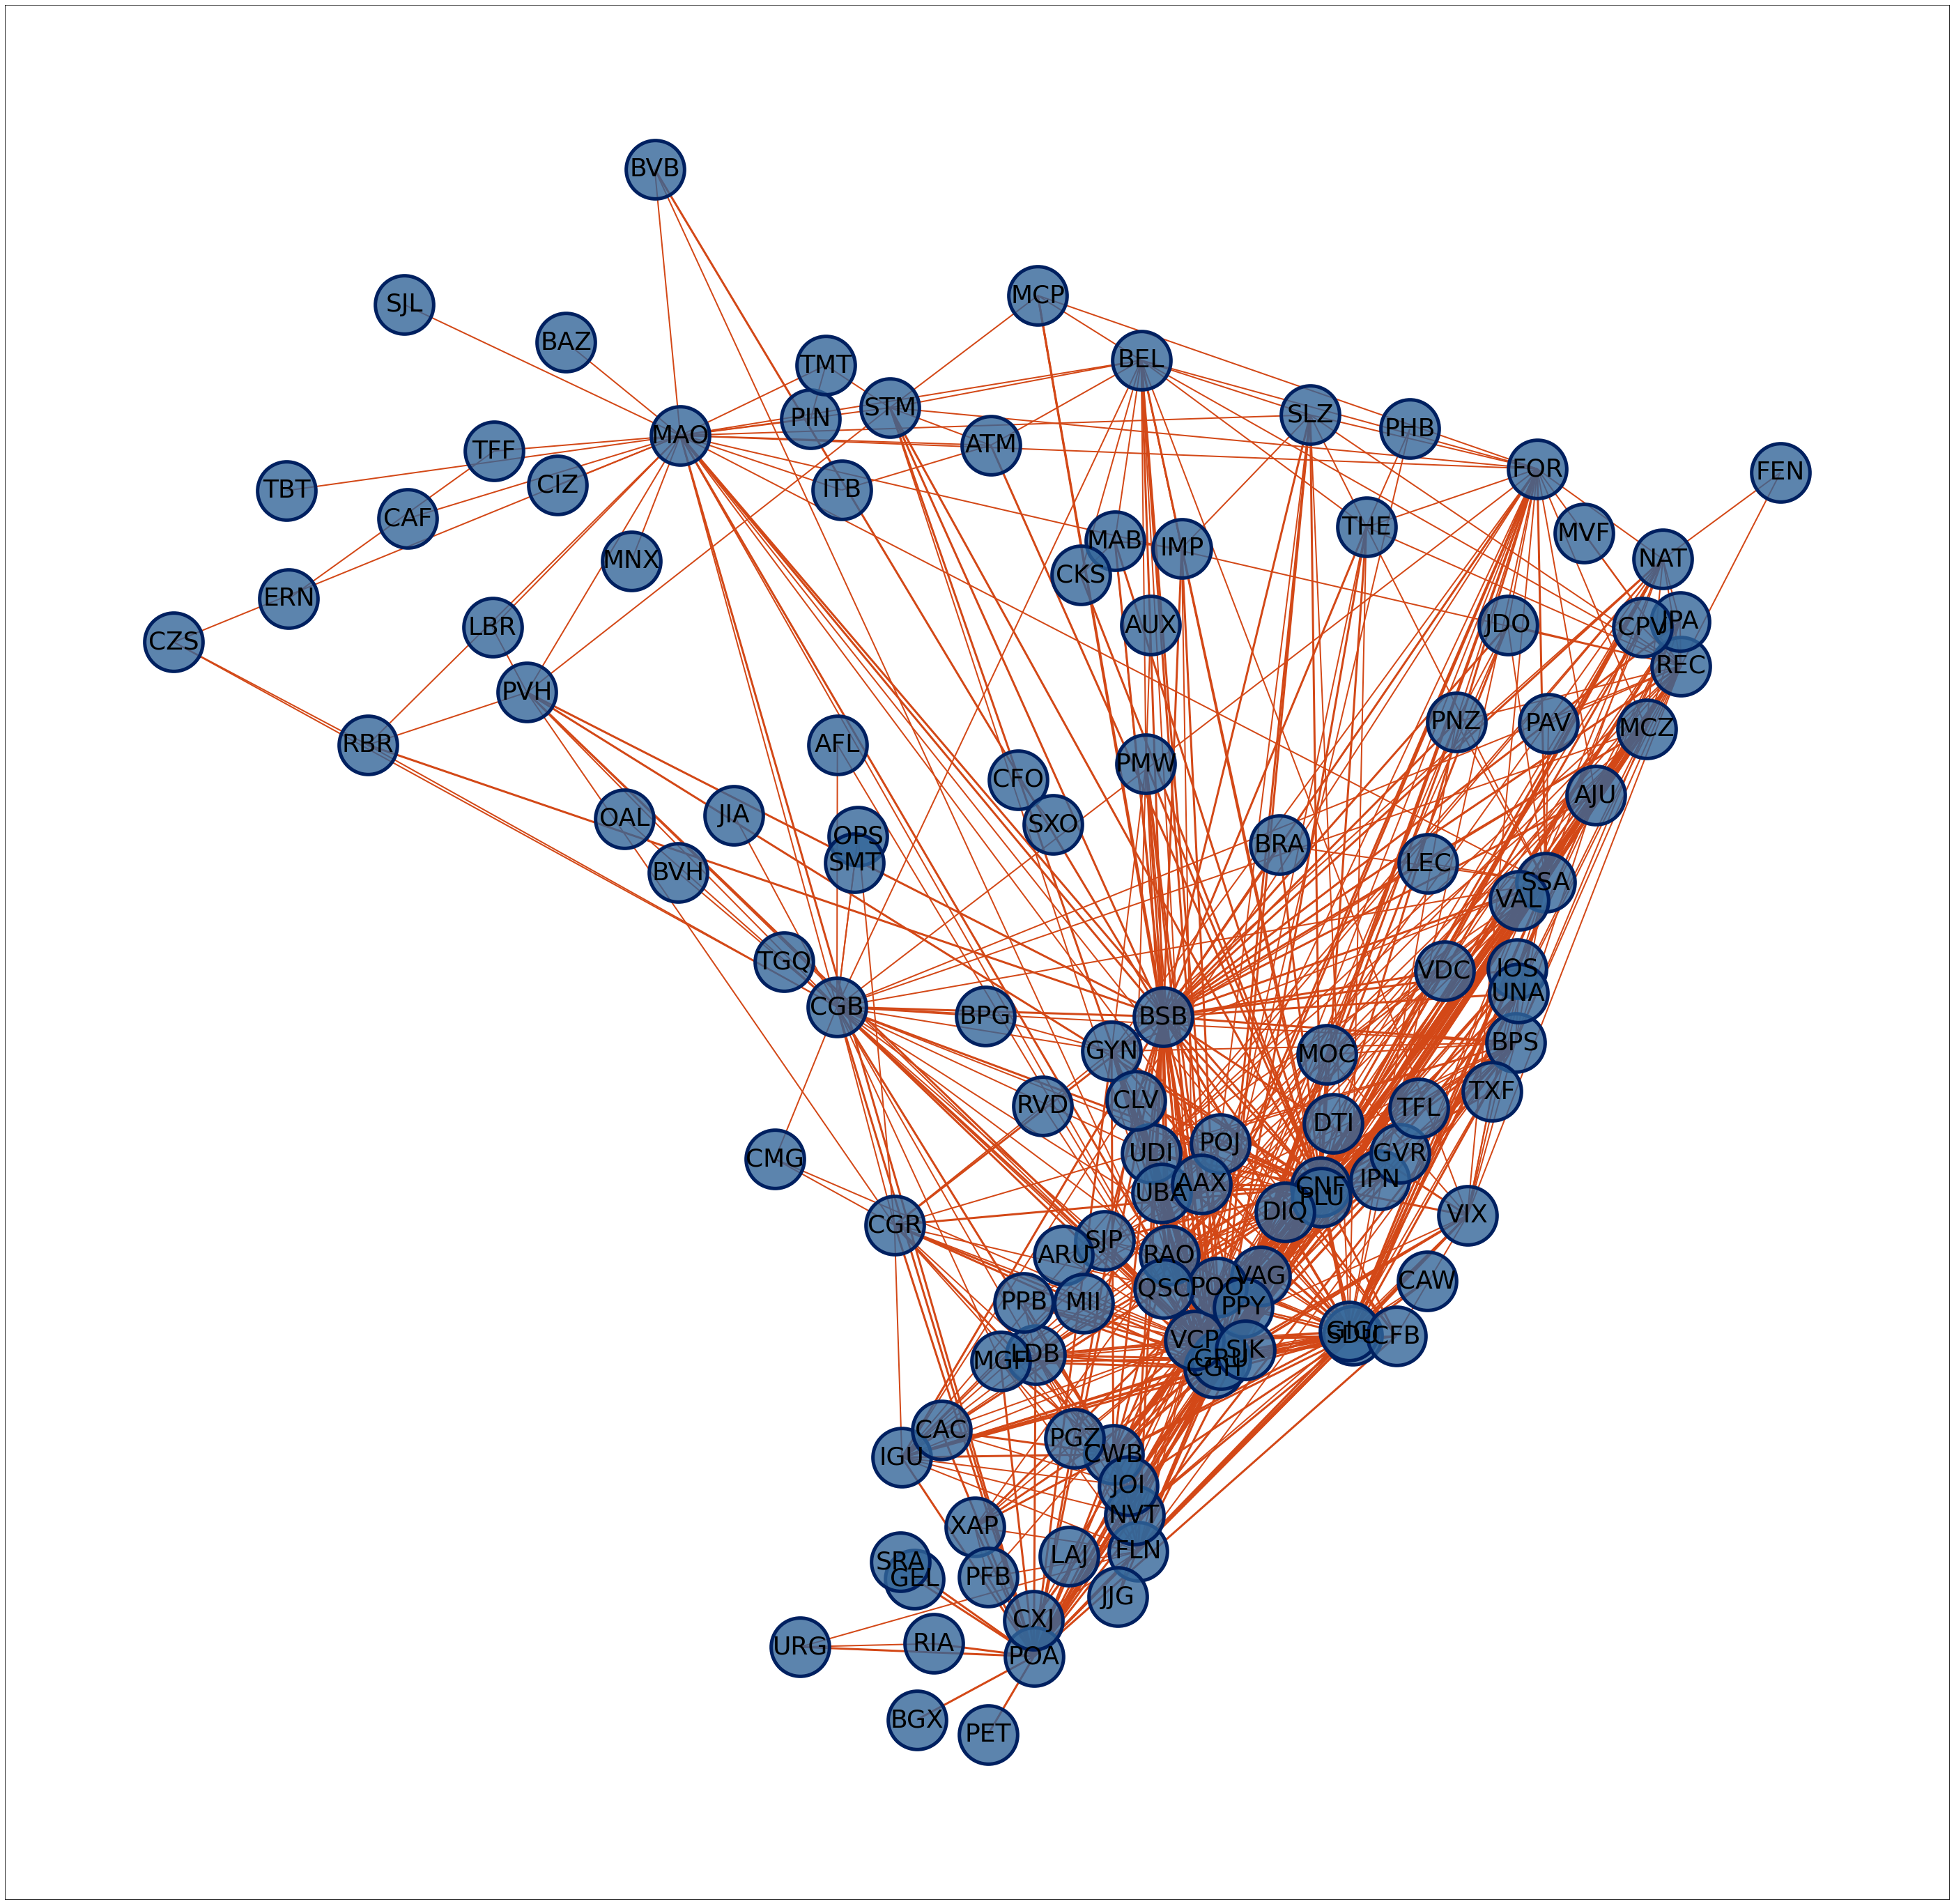

In [8]:
G = desenha_grafo2(2018, 'Map')

In [9]:
#Remoção dos 2 aeroportos problemáticos
G.remove_node('SXO')
G.remove_node('CFO')

# Pergunta-1 
Qual o grau médio, ou seja, número de outros aeroportos conectados, dos aeroportos brasileiros com voos em 2018?

Resposta: Grau médio => aproximanadamente 10

In [10]:
soma_grau=0
contador=0

d=list(nx.degree(G))

for i, grau in d:
  soma_grau = soma_grau + grau
  contador += 1

media = soma_grau/contador

print('Grau médio entre os aeroporto é:', media)
print(contador)


Grau médio entre os aeroporto é: 10.293103448275861
116


# Pergunta-2 
Qual aeroporto brasileiro voava, em 2018, para mais cidades distintas?

Resposta : Aeroporto de Viracopos na cidade de Campinas - SP com 67 conexões. 

In [11]:
d=list(nx.degree(G))
d.sort(reverse = True, key=lambda x:x[1])
d[0]






('VCP', 67)

Rank - Segundo aeroporto

In [12]:
d[1]

('CNF', 55)

Rank Terceiro aeroporto

In [13]:
d[2]

('GRU', 53)

# Pergunta-3
Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?

Resposta: Aeroporto Regional de Eirunepé - Amaury Feitosa Tomaz na cidade de Eirunepé no interior do estado do Amazonas (AM)

In [14]:
maior_escala = nx.diameter(G) # Resultado da função diâmetro 
lista_aeroporto = G.nodes()

resultado_pesquisa_2018 = []
resultado_pesquisa_2018 = pd.DataFrame(columns=('origem', 'destino'))

aeroporto_origem = 0
aeroporto_destino = 0

for aeroporto_origem in lista_aeroporto:
  for aeroporto_destino in lista_aeroporto:
    escala = nx.shortest_path_length(G, aeroporto_origem, aeroporto_destino)
    if maior_escala == escala: 
      novo_dado = {'origem': aeroporto_origem, 'destino': aeroporto_destino}
      resultado_pesquisa_2018 = resultado_pesquisa_2018.append(novo_dado, ignore_index=True)

resultado_pesquisa_2018


,origem,destino
0,AUX,ERN
1,TFL,ERN
2,DTI,ERN
3,ERN,AUX
4,ERN,TFL
5,ERN,DTI
6,ERN,POO
7,ERN,PPY
8,POO,ERN
9,PPY,ERN
